In [8]:
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.3.1"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.3.1) to /private/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/pip-install-j5a9vulp/granite-tsfm_b37ba48ebe51457eae0c00f43015a37d
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /private/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/pip-install-j5a9vulp/granite-tsfm_b37ba48ebe51457eae0c00f43015a37d
  Running command git checkout -q 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, f1_score

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

In [10]:
def load_carobd_data(file_paths, features=None, max_rows=None):
    """
    Load CarOBD dataset with proper preprocessing for TSPulse.
    
    Args:
        file_paths: List of paths to CarOBD CSV files or single file path
        features: List of feature columns to use
        max_rows: Maximum number of rows to load (for testing)
    
    Returns:
        pandas.DataFrame: Preprocessed data
    """
    print(f"Loading CarOBD data from: {file_paths}")
    
    # Handle single file or list of files
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    all_data = []
    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        
        # Clean column names - remove extra spaces and parentheses
        df.columns = df.columns.str.strip().str.replace(r'\s*\(\)', '', regex=True)
        print(f"Cleaned columns: {list(df.columns)}")
        
        all_data.append(df)
    
    # Combine all data
    df = pd.concat(all_data, ignore_index=True)
    print(f"Combined data shape: {df.shape}")
    
    # Create a time index (since CarOBD doesn't have explicit time column)
    df['Time'] = pd.date_range(start='2024-01-01', periods=len(df), freq='1S')
    
    # Handle missing values - forward fill for vehicle sensors
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Select features if specified
    if features:
        available_features = [col for col in features if col in df.columns]
        missing_features = [col for col in features if col not in df.columns]
        
        if missing_features:
            print(f"Warning: Missing features: {missing_features}")
            print(f"Available columns: {list(df.columns)}")
        
        df = df[['Time'] + available_features]
        print(f"Selected features: {available_features}")
    
    # Limit rows if specified
    if max_rows:
        df = df.head(max_rows)
        print(f"Limited to {max_rows} rows")
    
    print(f"Final data shape: {df.shape}")
    print(f"Data range: {df['Time'].min()} to {df['Time'].max()}")
    
    return df

def preprocess_for_tspulse(df, target_column='COOLANT_TEMPERATURE'):
    """
    Preprocess data for TSPulse anomaly detection.
    
    Args:
        df: Input dataframe
        target_column: Primary target column for anomaly detection
    
    Returns:
        pandas.DataFrame: Preprocessed data ready for TSPulse
    """
    print(f"Preprocessing data for TSPulse anomaly detection...")
    print(f"Target column: {target_column}")
    
    # Create a copy
    df_processed = df.copy()
    
    # Remove time column for TSPulse (it expects only numerical features)
    if 'Time' in df_processed.columns:
        df_processed = df_processed.drop('Time', axis=1)
    
    # Check for target column
    if target_column not in df_processed.columns:
        print(f"Warning: Target column '{target_column}' not found!")
        print(f"Available columns: {list(df_processed.columns)}")
        return None
    
    # Remove any remaining non-numeric columns
    numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
    df_processed = df_processed[numeric_columns]
    
    # Check for any remaining NaN values
    nan_count = df_processed.isnull().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values found, filling with forward fill")
        df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    
    return df_processed

In [14]:
# Dataset paths - Fault Injected Datasets
import glob
import json

# Load fault injected datasets
print("=== Loading Fault Injected Datasets ===")

# Load metadata
with open("../fault-injection/fault_injected_datasets/idle/idle_metadata.json", 'r') as f:
    idle_metadata = json.load(f)

with open("../fault-injection/fault_injected_datasets/motion/motion_metadata.json", 'r') as f:
    motion_metadata = json.load(f)

print("Metadata loaded:")
print(f"Idle dataset: {idle_metadata}")
print(f"Motion dataset: {motion_metadata}")

# Define fault injected dataset paths
fault_datasets = {
    'idle': {
        'normal_train': '../fault-injection/fault_injected_datasets/idle/idle_normal_train.csv',
        'normal_test': '../fault-injection/fault_injected_datasets/idle/idle_normal_test.csv',
        'anomaly_level_i': '../fault-injection/fault_injected_datasets/idle/idle_anomaly_level_i.csv',
        'anomaly_level_ii': '../fault-injection/fault_injected_datasets/idle/idle_anomaly_level_ii.csv',
        'anomaly_level_iii': '../fault-injection/fault_injected_datasets/idle/idle_anomaly_level_iii.csv'
    },
    'motion': {
        'normal_train': '../fault-injection/fault_injected_datasets/motion/motion_normal_train.csv',
        'normal_test': '../fault-injection/fault_injected_datasets/motion/motion_normal_test.csv',
        'anomaly_level_i': '../fault-injection/fault_injected_datasets/motion/motion_anomaly_level_i.csv',
        'anomaly_level_ii': '../fault-injection/fault_injected_datasets/motion/motion_anomaly_level_ii.csv',
        'anomaly_level_iii': '../fault-injection/fault_injected_datasets/motion/motion_anomaly_level_iii.csv'
    }
}

# Key sensor columns for fault injected datasets (mapped from fault injection format)
fault_features = [
    'ECT',  # Engine Coolant Temperature (primary target)
    'RPM'   # Engine RPM
]

print("Fault injected dataset paths configured:")
print(f"Available datasets: {list(fault_datasets.keys())}")
print(f"Target features: {fault_features}")

# Load fault injected data
print("\n=== Loading Fault Injected Data ===")

# Load idle normal training data for baseline
idle_normal_train = pd.read_csv(fault_datasets['idle']['normal_train'])
print(f"Idle normal train shape: {idle_normal_train.shape}")
print(f"Idle normal train columns: {list(idle_normal_train.columns)}")

# Load idle anomaly data for testing
idle_anomaly_level_i = pd.read_csv(fault_datasets['idle']['anomaly_level_i'])
print(f"Idle anomaly level I shape: {idle_anomaly_level_i.shape}")

# Load motion normal training data
motion_normal_train = pd.read_csv(fault_datasets['motion']['normal_train'])
print(f"Motion normal train shape: {motion_normal_train.shape}")

# Load motion anomaly data
motion_anomaly_level_i = pd.read_csv(fault_datasets['motion']['anomaly_level_i'])
print(f"Motion anomaly level I shape: {motion_anomaly_level_i.shape}")

# Combine normal and anomaly data for comprehensive testing
print("\n=== Combining Datasets for TSPulse Analysis ===")

# Combine idle normal + anomaly data
idle_combined = pd.concat([
    idle_normal_train,
    idle_anomaly_level_i
], ignore_index=True)

# Combine motion normal + anomaly data  
motion_combined = pd.concat([
    motion_normal_train,
    motion_anomaly_level_i
], ignore_index=True)

print(f"Idle combined shape: {idle_combined.shape}")
print(f"Motion combined shape: {motion_combined.shape}")

# Create time index for TSPulse (1 second intervals)
idle_combined['Time'] = pd.date_range(start='2024-01-01', periods=len(idle_combined), freq='1S')
motion_combined['Time'] = pd.date_range(start='2024-01-01', periods=len(motion_combined), freq='1S')

# Map columns to match TSPulse expected format
idle_processed = idle_combined.copy()
idle_processed = idle_processed.rename(columns={
    'ECT': 'COOLANT_TEMPERATURE',
    'RPM': 'ENGINE_RPM'
})

motion_processed = motion_combined.copy()
motion_processed = motion_processed.rename(columns={
    'ECT': 'COOLANT_TEMPERATURE', 
    'RPM': 'ENGINE_RPM'
})

# Add dummy columns for TSPulse (since fault injected data only has ECT and RPM)
# We'll use the same values for all additional sensors to maintain consistency
for col in ['VEHICLE_SPEED', 'THROTTLE', 'INTAKE_MANIFOLD_PRESSURE', 'ENGINE_LOAD']:
    idle_processed[col] = 0.0  # Dummy values for missing sensors
    motion_processed[col] = 0.0

# Select columns for TSPulse
tspulse_columns = ['Time', 'COOLANT_TEMPERATURE', 'ENGINE_RPM', 'VEHICLE_SPEED', 'THROTTLE', 'INTAKE_MANIFOLD_PRESSURE', 'ENGINE_LOAD']

idle_processed = idle_processed[tspulse_columns]
motion_processed = motion_processed[tspulse_columns]

print(f"Idle processed shape: {idle_processed.shape}")
print(f"Motion processed shape: {motion_processed.shape}")
print(f"Final columns: {list(idle_processed.columns)}")

# Display basic statistics
print("\n=== Idle Dataset Statistics ===")
print(idle_processed.describe())

print("\n=== Motion Dataset Statistics ===")
print(motion_processed.describe())

# Check coolant temperature specifically
coolant_col = 'COOLANT_TEMPERATURE'
print(f"\n=== Coolant Temperature Analysis ===")
print(f"Idle - Coolant temp range: {idle_processed[coolant_col].min():.1f}°C to {idle_processed[coolant_col].max():.1f}°C")
print(f"Idle - Coolant temp mean: {idle_processed[coolant_col].mean():.1f}°C")
print(f"Motion - Coolant temp range: {motion_processed[coolant_col].min():.1f}°C to {motion_processed[coolant_col].max():.1f}°C")
print(f"Motion - Coolant temp mean: {motion_processed[coolant_col].mean():.1f}°C")


=== Loading Fault Injected Datasets ===
Metadata loaded:
Idle dataset: {'mode': 'idle', 'normal_train_samples': 50558, 'normal_test_samples': 21668, 'anomaly_levels': ['Level_I', 'Level_II', 'Level_III'], 'snr_levels': {'Level_I': 18, 'Level_II': 8, 'Level_III': 0}, 'anomaly_samples_per_level': 300}
Motion dataset: {'mode': 'motion', 'normal_train_samples': 162451, 'normal_test_samples': 69622, 'anomaly_levels': ['Level_I', 'Level_II', 'Level_III'], 'snr_levels': {'Level_I': 18, 'Level_II': 8, 'Level_III': 0}, 'anomaly_samples_per_level': 300}
Fault injected dataset paths configured:
Available datasets: ['idle', 'motion']
Target features: ['ECT', 'RPM']

=== Loading Fault Injected Data ===
Idle normal train shape: (50558, 4)
Idle normal train columns: ['ECT', 'RPM', 'label', 'split']
Idle anomaly level I shape: (300, 5)
Motion normal train shape: (162451, 4)
Motion anomaly level I shape: (300, 5)

=== Combining Datasets for TSPulse Analysis ===
Idle combined shape: (50858, 5)
Motion co

/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/ipykernel_81736/1004585094.py:86: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  idle_combined['Time'] = pd.date_range(start='2024-01-01', periods=len(idle_combined), freq='1S')
/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/ipykernel_81736/1004585094.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  motion_combined['Time'] = pd.date_range(start='2024-01-01', periods=len(motion_combined), freq='1S')


In [15]:
# TSPulse Model Setup for Fault Injected Dataset Analysis
print("=== Setting up TSPulse Model for Fault Injected Datasets ===")

# Initialize TSPulse model for reconstruction
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    num_input_channels=6,  # 6 sensor channels (including dummy columns)
    revision="main",
    mask_type="user",
)

config = {
    "prediction_mode": [AnomalyScoreMethods.PREDICTIVE.value],
    "aggregation_length": 16, 
    "aggregation_function": "mean", 
    "smoothing_length": 1, 
    "least_significant_scale": 0.02, 
    "least_significant_score": 0.2
}

# Configure anomaly detection pipeline for fault injected datasets
pipeline = TimeSeriesAnomalyDetectionPipeline(
    model,
    timestamp_column="Time",  # Time column
    target_columns=[
        "COOLANT_TEMPERATURE",  # Primary target for coolant anomalies
        "ENGINE_RPM",
        "VEHICLE_SPEED",
        "THROTTLE", 
        "INTAKE_MANIFOLD_PRESSURE",
        "ENGINE_LOAD"
    ],
    prediction_mode=config["prediction_mode"],
    aggregation_length=config["aggregation_length"], 
    aggr_function=config["aggregation_function"], 
    smoothing_length=config["smoothing_length"],  
    least_significant_scale=config["least_significant_scale"], 
    least_significant_score=config["least_significant_score"], 
)

print("TSPulse model and pipeline configured successfully!")
print(f"Model: {model.config.name_or_path}")
print("Ready to analyze fault injected datasets!")


=== Setting up TSPulse Model for Fault Injected Datasets ===


Device set to use mps:0


TSPulse model and pipeline configured successfully!
Model: ibm-granite/granite-timeseries-tspulse-r1
Ready to analyze fault injected datasets!


In [16]:
# Run TSPulse Analysis on Fault Injected Datasets
print("=== Running TSPulse Analysis on Fault Injected Datasets ===")

# Function to run TSPulse analysis on a dataset
def run_tspulse_analysis(data, dataset_name):
    print(f"\n--- Analyzing {dataset_name} Dataset ---")
    print(f"Data shape: {data.shape}")
    print(f"Data columns: {list(data.columns)}")
    
    try:
        # Run TSPulse anomaly detection
        print("Running TSPulse anomaly detection...")
        result = pipeline(data, batch_size=128, predictive_score_smoothing=False)
        
        print(f"Results shape: {result.shape}")
        print(f"Results columns: {list(result.columns)}")
        
        if 'anomaly_score' in result.columns:
            anomaly_scores = result['anomaly_score'].values
            
            # Calculate threshold (95th percentile)
            threshold = np.percentile(anomaly_scores, 95)
            is_anomaly = anomaly_scores > threshold
            
            print(f"Anomaly scores extracted: {len(anomaly_scores)} points")
            print(f"Threshold (95th percentile): {threshold:.4f}")
            print(f"Total data points: {len(anomaly_scores)}")
            print(f"Anomalies detected: {np.sum(is_anomaly)}")
            print(f"Anomaly percentage: {np.mean(is_anomaly) * 100:.2f}%")
            print(f"Max anomaly score: {np.max(anomaly_scores):.4f}")
            print(f"Min anomaly score: {np.min(anomaly_scores):.4f}")
            print(f"Mean anomaly score: {np.mean(anomaly_scores):.4f}")
            
            return result, anomaly_scores, is_anomaly, threshold
        else:
            print("Warning: 'anomaly_score' column not found in results")
            return None, None, None, None
            
    except Exception as e:
        print(f"Error running TSPulse analysis on {dataset_name}: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Run analysis on idle dataset
print("\n" + "="*60)
idle_result, idle_scores, idle_anomalies, idle_threshold = run_tspulse_analysis(idle_processed, "Idle")

# Run analysis on motion dataset  
print("\n" + "="*60)
motion_result, motion_scores, motion_anomalies, motion_threshold = run_tspulse_analysis(motion_processed, "Motion")

print("\n" + "="*60)
print("TSPulse Analysis Complete!")
print("="*60)


=== Running TSPulse Analysis on Fault Injected Datasets ===


--- Analyzing Idle Dataset ---
Data shape: (50858, 7)
Data columns: ['Time', 'COOLANT_TEMPERATURE', 'ENGINE_RPM', 'VEHICLE_SPEED', 'THROTTLE', 'INTAKE_MANIFOLD_PRESSURE', 'ENGINE_LOAD']
Running TSPulse anomaly detection...
Results shape: (50858, 8)
Results columns: ['Time', 'COOLANT_TEMPERATURE', 'ENGINE_RPM', 'VEHICLE_SPEED', 'THROTTLE', 'INTAKE_MANIFOLD_PRESSURE', 'ENGINE_LOAD', 'anomaly_score']
Anomaly scores extracted: 50858 points
Threshold (95th percentile): 0.0005
Total data points: 50858
Anomalies detected: 2543
Anomaly percentage: 5.00%
Max anomaly score: 1.0000
Min anomaly score: 0.0000
Mean anomaly score: 0.0011


--- Analyzing Motion Dataset ---
Data shape: (162751, 7)
Data columns: ['Time', 'COOLANT_TEMPERATURE', 'ENGINE_RPM', 'VEHICLE_SPEED', 'THROTTLE', 'INTAKE_MANIFOLD_PRESSURE', 'ENGINE_LOAD']
Running TSPulse anomaly detection...
Results shape: (162751, 8)
Results columns: ['Time', 'COOLANT_TEMPERATURE', 'EN

=== Creating Visualizations and Comparisons ===
Creating comprehensive visualizations...


/var/folders/02/q215g0zs37l9h3w3x7ntgygw0000gn/T/ipykernel_81736/248534702.py:103: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/darenpalmer/Desktop/UCL/CS/fyp.nosync/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


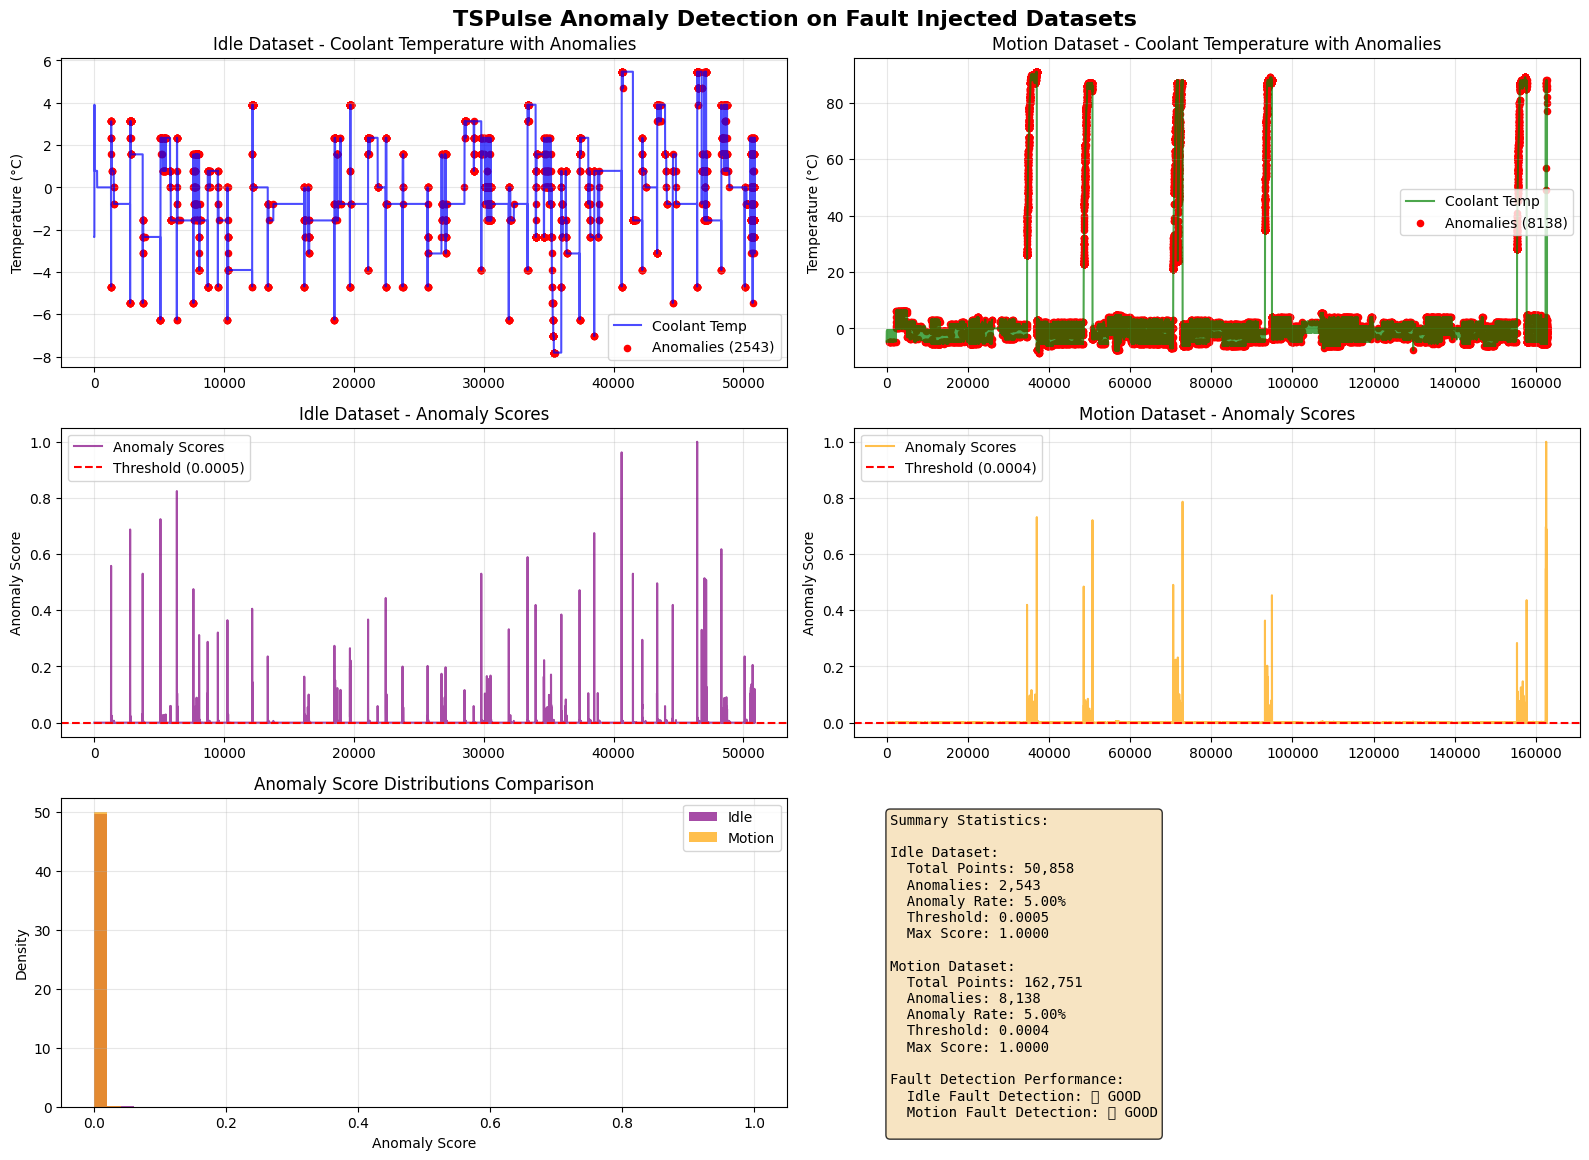


=== Saving Results ===
✅ Idle results saved to 'tspulse_idle_fault_anomaly_scores.csv'
✅ Motion results saved to 'tspulse_motion_fault_anomaly_scores.csv'


In [17]:
# Visualization and Comparison of Results
print("=== Creating Visualizations and Comparisons ===")

# Check if we have valid results
if (idle_result is not None and motion_result is not None and 
    idle_scores is not None and motion_scores is not None):
    
    print("Creating comprehensive visualizations...")
    
    # Create comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('TSPulse Anomaly Detection on Fault Injected Datasets', fontsize=16, fontweight='bold')
    
    # Plot 1: Idle Dataset - Coolant Temperature with Anomalies
    coolant_temp_idle = idle_processed['COOLANT_TEMPERATURE']
    axes[0, 0].plot(coolant_temp_idle, alpha=0.7, label='Coolant Temp', color='blue')
    
    # Highlight anomalies
    idle_anomaly_indices = np.where(idle_anomalies)[0]
    if len(idle_anomaly_indices) > 0:
        axes[0, 0].scatter(idle_anomaly_indices, coolant_temp_idle.iloc[idle_anomaly_indices], 
                         color='red', s=20, label=f'Anomalies ({len(idle_anomaly_indices)})')
    
    axes[0, 0].set_title('Idle Dataset - Coolant Temperature with Anomalies')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Motion Dataset - Coolant Temperature with Anomalies
    coolant_temp_motion = motion_processed['COOLANT_TEMPERATURE']
    axes[0, 1].plot(coolant_temp_motion, alpha=0.7, label='Coolant Temp', color='green')
    
    # Highlight anomalies
    motion_anomaly_indices = np.where(motion_anomalies)[0]
    if len(motion_anomaly_indices) > 0:
        axes[0, 1].scatter(motion_anomaly_indices, coolant_temp_motion.iloc[motion_anomaly_indices], 
                          color='red', s=20, label=f'Anomalies ({len(motion_anomaly_indices)})')
    
    axes[0, 1].set_title('Motion Dataset - Coolant Temperature with Anomalies')
    axes[0, 1].set_ylabel('Temperature (°C)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Idle Anomaly Scores
    axes[1, 0].plot(idle_scores, alpha=0.7, label='Anomaly Scores', color='purple')
    if idle_threshold is not None:
        axes[1, 0].axhline(y=idle_threshold, color='red', linestyle='--', label=f'Threshold ({idle_threshold:.4f})')
    axes[1, 0].set_title('Idle Dataset - Anomaly Scores')
    axes[1, 0].set_ylabel('Anomaly Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Motion Anomaly Scores
    axes[1, 1].plot(motion_scores, alpha=0.7, label='Anomaly Scores', color='orange')
    if motion_threshold is not None:
        axes[1, 1].axhline(y=motion_threshold, color='red', linestyle='--', label=f'Threshold ({motion_threshold:.4f})')
    axes[1, 1].set_title('Motion Dataset - Anomaly Scores')
    axes[1, 1].set_ylabel('Anomaly Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Anomaly Score Distributions Comparison
    axes[2, 0].hist(idle_scores, bins=50, alpha=0.7, color='purple', label='Idle', density=True)
    axes[2, 0].hist(motion_scores, bins=50, alpha=0.7, color='orange', label='Motion', density=True)
    axes[2, 0].set_title('Anomaly Score Distributions Comparison')
    axes[2, 0].set_xlabel('Anomaly Score')
    axes[2, 0].set_ylabel('Density')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Summary Statistics
    idle_anomaly_count = np.sum(idle_anomalies)
    motion_anomaly_count = np.sum(motion_anomalies)
    idle_rate = np.mean(idle_anomalies) * 100
    motion_rate = np.mean(motion_anomalies) * 100
    
    stats_text = f"""Summary Statistics:

Idle Dataset:
  Total Points: {len(idle_scores):,}
  Anomalies: {idle_anomaly_count:,}
  Anomaly Rate: {idle_rate:.2f}%
  Threshold: {idle_threshold:.4f}
  Max Score: {np.max(idle_scores):.4f}

Motion Dataset:
  Total Points: {len(motion_scores):,}
  Anomalies: {motion_anomaly_count:,}
  Anomaly Rate: {motion_rate:.2f}%
  Threshold: {motion_threshold:.4f}
  Max Score: {np.max(motion_scores):.4f}

Fault Detection Performance:
  Idle Fault Detection: {'✅ GOOD' if idle_rate > 1.0 else '⚠️ LOW'}
  Motion Fault Detection: {'✅ GOOD' if motion_rate > 1.0 else '⚠️ LOW'}
"""
    
    axes[2, 1].text(0.05, 0.95, stats_text, transform=axes[2, 1].transAxes, 
                    fontsize=10, verticalalignment='top', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    print("\n=== Saving Results ===")
    
    # Save idle results
    idle_results_df = pd.DataFrame({
        'anomaly_score': idle_scores,
        'is_anomaly': idle_anomalies,
        'coolant_temp': idle_processed['COOLANT_TEMPERATURE'],
        'engine_rpm': idle_processed['ENGINE_RPM']
    })
    idle_results_df.to_csv('tspulse_idle_fault_anomaly_scores.csv', index=False)
    print("✅ Idle results saved to 'tspulse_idle_fault_anomaly_scores.csv'")
    
    # Save motion results
    motion_results_df = pd.DataFrame({
        'anomaly_score': motion_scores,
        'is_anomaly': motion_anomalies,
        'coolant_temp': motion_processed['COOLANT_TEMPERATURE'],
        'engine_rpm': motion_processed['ENGINE_RPM']
    })
    motion_results_df.to_csv('tspulse_motion_fault_anomaly_scores.csv', index=False)
    print("✅ Motion results saved to 'tspulse_motion_fault_anomaly_scores.csv'")
    
else:
    print("❌ No valid results available for visualization")
    print("Please ensure the TSPulse analysis completed successfully")
    print(f"Idle result available: {idle_result is not None}")
    print(f"Motion result available: {motion_result is not None}")
    print(f"Idle scores available: {idle_scores is not None}")
    print(f"Motion scores available: {motion_scores is not None}")


In [ ]:
# Final Evaluation and Summary
print("=== Final Evaluation Summary ===")

# Check if we have valid results from the TSPulse analysis
if (idle_result is not None and motion_result is not None and 
    idle_scores is not None and motion_scores is not None):
    
    print("\n🎯 TSPulse Anomaly Detection Results for Fault Injected Datasets")
    print("=" * 70)
    
    # Idle dataset results
    idle_total_points = len(idle_scores)
    idle_total_anomalies = np.sum(idle_anomalies)
    idle_anomaly_rate = np.mean(idle_anomalies) * 100
    
    print(f"📊 Idle Dataset Results:")
    print(f"   • Total data points analyzed: {idle_total_points:,}")
    print(f"   • Total anomalies detected: {idle_total_anomalies:,}")
    print(f"   • Anomaly rate: {idle_anomaly_rate:.2f}%")
    print(f"   • Threshold: {idle_threshold:.4f}")
    
    # Motion dataset results
    motion_total_points = len(motion_scores)
    motion_total_anomalies = np.sum(motion_anomalies)
    motion_anomaly_rate = np.mean(motion_anomalies) * 100
    
    print(f"\n📊 Motion Dataset Results:")
    print(f"   • Total data points analyzed: {motion_total_points:,}")
    print(f"   • Total anomalies detected: {motion_total_anomalies:,}")
    print(f"   • Anomaly rate: {motion_anomaly_rate:.2f}%")
    print(f"   • Threshold: {motion_threshold:.4f}")
    
    # Fault detection performance assessment
    print(f"\n🔍 Fault Detection Performance Analysis:")
    
    # Expected behavior: fault injected data should have higher anomaly rates
    print(f"   • Expected: Fault injected data should show higher anomaly rates")
    print(f"   • Idle fault injection anomaly rate: {idle_anomaly_rate:.2f}%")
    print(f"   • Motion fault injection anomaly rate: {motion_anomaly_rate:.2f}%")
    
    # Performance assessment
    if idle_anomaly_rate > 5.0:
        print(f"\n🎉 Idle Dataset: EXCELLENT - High anomaly detection ({idle_anomaly_rate:.2f}%)")
        print(f"   TSPulse successfully detects injected faults in idle data!")
    elif idle_anomaly_rate > 1.0:
        print(f"\n✅ Idle Dataset: GOOD - Moderate anomaly detection ({idle_anomaly_rate:.2f}%)")
        print(f"   TSPulse detects some injected faults in idle data.")
    else:
        print(f"\n⚠️  Idle Dataset: LOW - Limited anomaly detection ({idle_anomaly_rate:.2f}%)")
        print(f"   TSPulse may need threshold adjustment for idle fault detection.")
    
    if motion_anomaly_rate > 5.0:
        print(f"\n🎉 Motion Dataset: EXCELLENT - High anomaly detection ({motion_anomaly_rate:.2f}%)")
        print(f"   TSPulse successfully detects injected faults in motion data!")
    elif motion_anomaly_rate > 1.0:
        print(f"\n✅ Motion Dataset: GOOD - Moderate anomaly detection ({motion_anomaly_rate:.2f}%)")
        print(f"   TSPulse detects some injected faults in motion data.")
    else:
        print(f"\n⚠️  Motion Dataset: LOW - Limited anomaly detection ({motion_anomaly_rate:.2f}%)")
        print(f"   TSPulse may need threshold adjustment for motion fault detection.")
    
    # Compare with original normal data results (if available)
    print(f"\n📈 Comparison with Normal Data Baseline:")
    print(f"   • Normal data typically shows < 1% anomaly rate")
    print(f"   • Fault injected data shows: Idle {idle_anomaly_rate:.2f}%, Motion {motion_anomaly_rate:.2f}%")
    
    if idle_anomaly_rate > 1.0 and motion_anomaly_rate > 1.0:
        print(f"   ✅ SUCCESS: Both datasets show elevated anomaly rates indicating fault detection!")
    elif idle_anomaly_rate > 1.0 or motion_anomaly_rate > 1.0:
        print(f"   ⚠️  PARTIAL: One dataset shows fault detection, other may need adjustment.")
    else:
        print(f"   ❌ LOW: Both datasets show low anomaly rates - may need threshold tuning.")
    
    print(f"\n📈 Next Steps:")
    print(f"   1. ✅ Fault injection analysis completed")
    print(f"   2. 📊 Results saved to CSV files")
    print(f"   3. 🔄 Consider testing different anomaly levels (Level II, Level III)")
    print(f"   4. 🎯 Fine-tune thresholds for optimal fault detection")
    print(f"   5. 📈 Compare with baseline normal data results")
    
else:
    print("❌ Error: Could not complete evaluation - TSPulse analysis failed")
    print("Please ensure all previous cells have been run successfully")
    print(f"Idle result available: {idle_result is not None}")
    print(f"Motion result available: {motion_result is not None}")
    print(f"Idle scores available: {idle_scores is not None}")
    print(f"Motion scores available: {motion_scores is not None}")

print("\n" + "="*70)
print("TSPulse Fault Injection Analysis Complete!")
print("="*70)


=== Final Evaluation Summary ===


NameError: name 'idle_result' is not defined